<a href="https://colab.research.google.com/github/Abishek46/Pneumonia-Detection-on-Chest-X-ray-Images-Using-Deep-Learning/blob/main/Pneumonia_Detection_on_Chest_X_ray_Images_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
!pip install keras

Import Libraries

In [4]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import random
from pathlib import Path

# Data science tools
import pandas as pd
import numpy as np

# Tensorflow for GPU
import tensorflow as tf
from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib

# Keras library for Modeling
import keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
#from keras.constraints import maxnorm
from keras import backend as K

# OpenCV
import cv2

# Resize images
from skimage.io import imread
from skimage.transform import resize

# Scikit-learn library
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Visualizations
from PIL import Image
import imgaug as aug
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.image as mimg  # images
%matplotlib inline
import seaborn as sns
import plotly.express as px


Downloading the data

In [5]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pabishek
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [00:23<00:00, 105MB/s]


In [6]:
base_dir = Path("chest-xray-pneumonia/chest_xray/chest_xray/")


In [7]:
# Directories for the training, validation, and test splits
train_dir = base_dir /"train/"
val_dir = base_dir /"val/"
test_dir = base_dir /"test/"

Data Loading

In [8]:
os.listdir(train_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [9]:
train_normal_dir = train_dir /"NORMAL" #to set the path to the normals in train set
train_pneumonia_dir = train_dir /"PNEUMONIA" #to set the path to the pneumonias in train set

In [10]:
os.listdir(val_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [11]:
valid_normal_dir = val_dir /"NORMAL" #to set the path to the normals in validation set
valid_pneumonia_dir = val_dir /"PNEUMONIA" #to set the path to the pneumonias in validation set

In [12]:
os.listdir(test_dir)

['.DS_Store', 'PNEUMONIA', 'NORMAL']

In [13]:
test_normal_dir = test_dir /"NORMAL" #to set the path to the normals in test set
test_pneumonia_dir = test_dir /"PNEUMONIA" #to set the path to the pneumonias in test set

In [14]:
train_normal= train_normal_dir.glob("*.jpeg") #to take the normal images from train set
train_pneumonia=train_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the train set
train_set=[]#to add all the train data into one list, we created a blank list

In [15]:
for img in train_normal: #to add every image of normals in trainset to the list
  train_set.append((img, 0)) #we add 0 with normal images as label
for img in train_pneumonia:#to add every image of pneumonias in trainset to the list
  train_set.append((img, 1)) #we add 1 with pneumonia images as label

In [16]:
print(train_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1171-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0970-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1030-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1264-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1177-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1247-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/IM-0738-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0601-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0699-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-0932-0001.jpeg'), 0

In [19]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can

In [20]:
train_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0


In [21]:
train_set=train_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
train_set=train_set.reset_index(drop=True) #to set the indexes as if first time
train_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1


In [22]:

valid_normal= valid_normal_dir.glob("*.jpeg") #to take the normal images from validation set
valid_pneumonia=valid_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the validation set
valid_set=[] #to add all the validation data into one list, we created a blank list

In [23]:
for img in valid_normal: #to add every image of normals in validationset to the list
  valid_set.append((img, 0)) #we add 0 with normal images as label
for img in valid_pneumonia:#to add every image of pneumonias in validationset to the list
  valid_set.append((img, 1))

In [24]:

print(valid_set[:15]) #to check what our list look like

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1438-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg'), 1), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg'),

In [25]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
valid_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [26]:
valid_set=valid_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
valid_set=valid_set.reset_index(drop=True) #to set the indexes as if first time
valid_set.head()


,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [27]:
test_normal= test_normal_dir.glob("*.jpeg") #to take the normal images from test set
test_pneumonia=test_pneumonia_dir.glob("*.jpeg") #to take the pneumonia images from the test set
test_set=[]#to add all the test data into one list, we created a blank list
for img in test_normal: #to add every image of normals in test set to the list
  test_set.append((img, 0)) #we add 0 with normal images as label
for img in test_pneumonia:#to add every image of pneumonias in test set to the list
  test_set.append((img, 1)) #we add 1 with pneumonia images as label
print(test_set[:15])

[(PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0039-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0280-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0315-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0069-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0033-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/IM-0021-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0339-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0058-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0328-0001.jpeg'), 0), (PosixPath('chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL/NORMAL2-IM-0045-0001.jpeg'), 0), (PosixPath('chest-xray-

In [28]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)#to create a dataframe from the list, so that we can use dataframe features
test_set.head() #to see the first 5 rows of our dataframe, only normals are shown since we added them first.

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


In [29]:
test_set=test_set.sample(frac=1) #to shuffle all the rows in dataframe so that we can see normal and pneumonia in random
test_set=test_set.reset_index(drop=True) #to set the indexes as if first time
test_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1


Data Visualization

In [30]:
# Normal Image
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [31]:
# Pneumonia Image
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


Normal / Pneumonia Image Visualization for Train Dataset

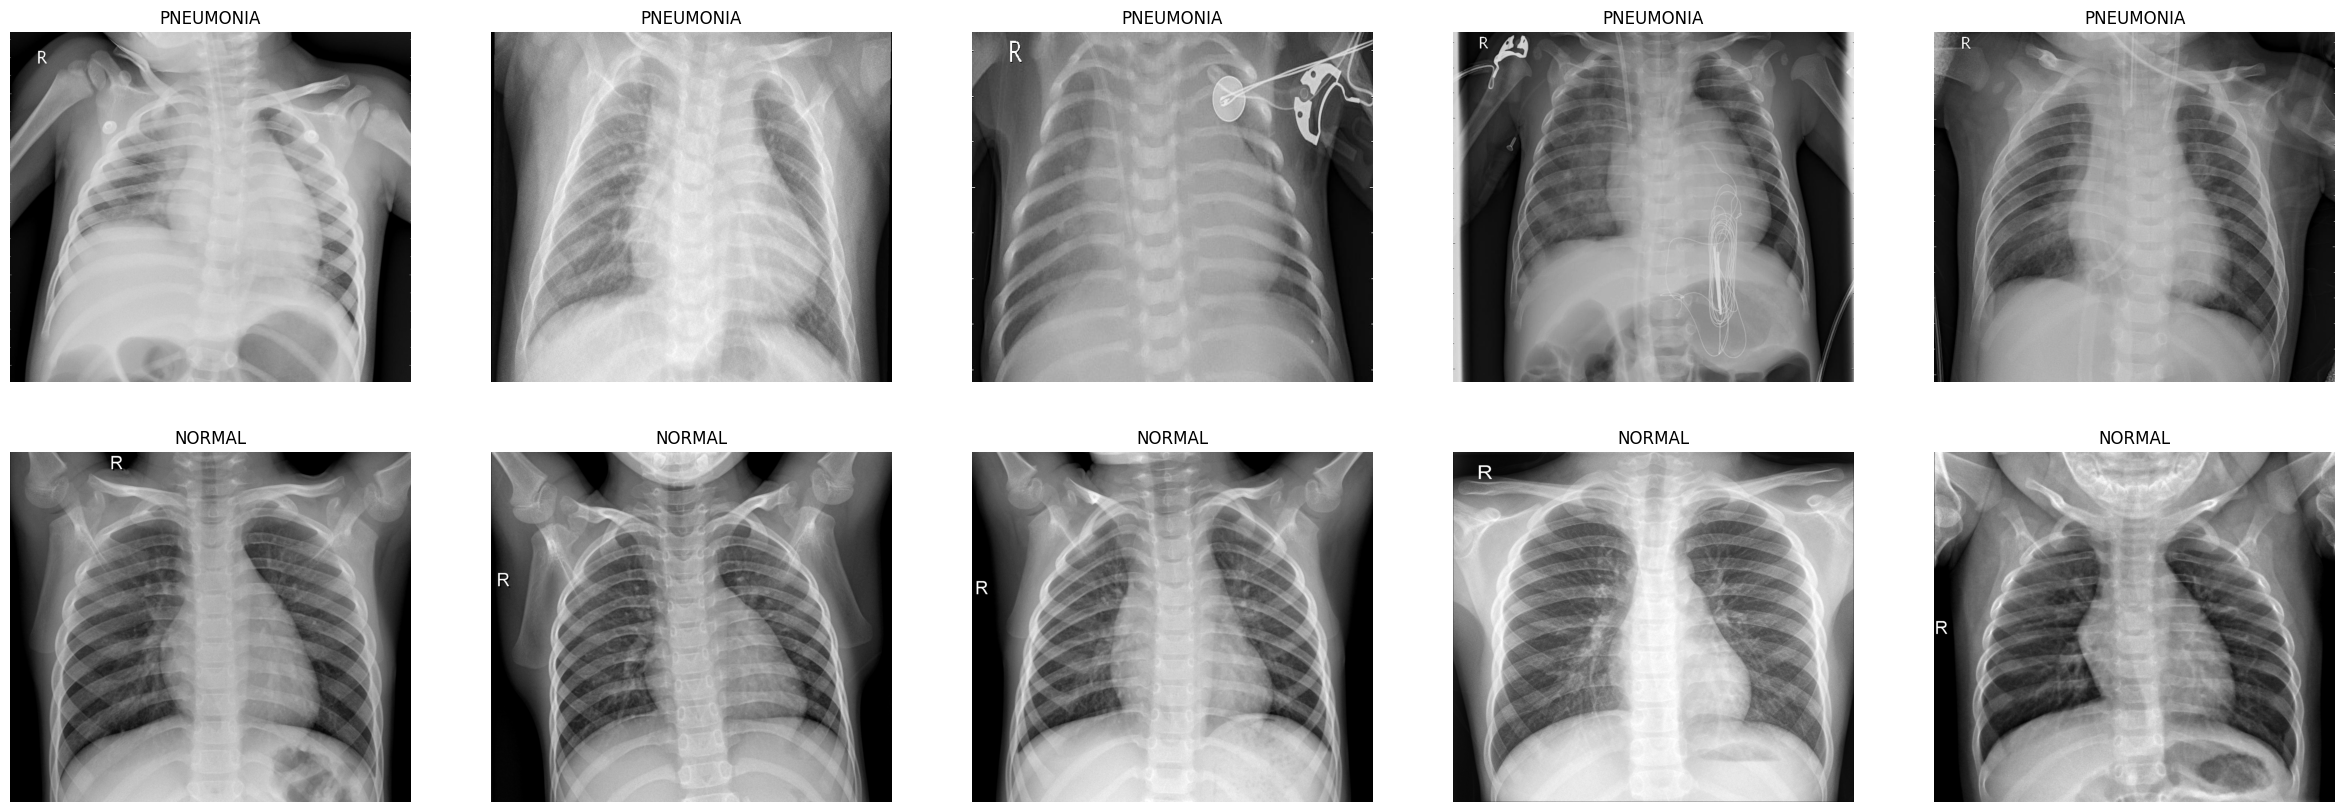

In [32]:
# Get few samples for both the classes
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()

# Concate the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize = (30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

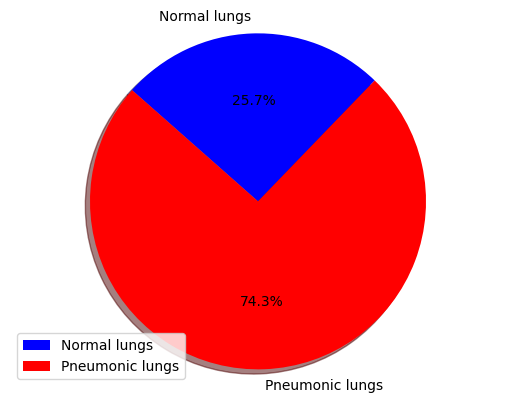

In [33]:
fig1,ax1= plt.subplots()
sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Normal lungs","Pneumonic lungs"], autopct="%1.1f%%", shadow=True, colors=["b","r"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Case Distribution')

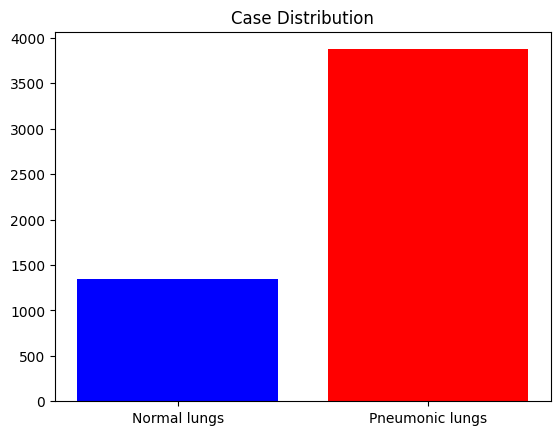

In [34]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Normal lungs", "Pneumonic lungs"], color=["blue", "red"])
plt.title("Case Distribution")

Data Preparation

In [35]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150


def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Reshaping images to preferred size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Data Normalization

In [36]:
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-35-0096977fee49>:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [37]:
# initialize multiple lists
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [38]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [39]:
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [40]:
# normalize and augment images
image_generator = ImageDataGenerator(
  featurewise_center = False, # set input mean to 0 over the dataset
  samplewise_center = False, # set each sample mean to 0
  featurewise_std_normalization = False, #divide inputs by std of the dataset
  samplewise_std_normalization = False, # divide each input by its std
  zca_whitening=False,  # apply ZCA whitening
  rotation_range =30, #randomly rotate images in the range
  zoom_range = 0.2, #randomly zoom image
  width_shift_range = 0.1, #randomly shift images horizontally
  height_shift_range = 0.1, #randomly shift images vertically
  horizontal_flip = True, #randomly flip images
  vertical_flip = False) #randomly flip images

image_generator.fit(X_train)

D. DATA MODELLING


D.1 Building CNN Model

In [41]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [44]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/15
183/183 [==============================] - 38s 210ms/step - loss: 0.1099 - accuracy: 0.9631 - val_loss: 0.1240 - val_accuracy: 0.9583 - lr: 2.7000e-05
Epoch 2/15
183/183 [==============================] - 26s 144ms/step - loss: 0.0931 - accuracy: 0.9662 - val_loss: 0.1175 - val_accuracy: 0.9626 - lr: 2.7000e-05
Epoch 3/15
183/183 [==============================] - 26s 142ms/step - loss: 0.1105 - accuracy: 0.9582 - val_loss: 0.1221 - val_accuracy: 0.9623 - lr: 2.7000e-05
Epoch 4/15
183/183 [==============================] - ETA: 0s - loss: 0.1075 - accuracy: 0.9631
Epoch 4: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
183/183 [==============================] - 27s 150ms/step - loss: 0.1075 - accuracy: 0.9631 - val_loss: 0.1402 - val_accuracy: 0.9529 - lr: 2.7000e-05
Epoch 5/15
183/183 [==============================] - 26s 141ms/step - loss: 0.1130 - accuracy: 0.9566 - val_loss: 0.1204 - val_accuracy: 0.9645 - lr: 8.1000e-06
Epoch 6/15
183/183 [=========

In [45]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

183/183 [==============================] - 2s 10ms/step - loss: 0.2454 - accuracy: 0.8970
Loss of the model is -  0.24543198943138123
183/183 [==============================] - 2s 10ms/step - loss: 0.2454 - accuracy: 0.8970
Accuracy of the model is -  89.70286846160889 %


EVALUATION

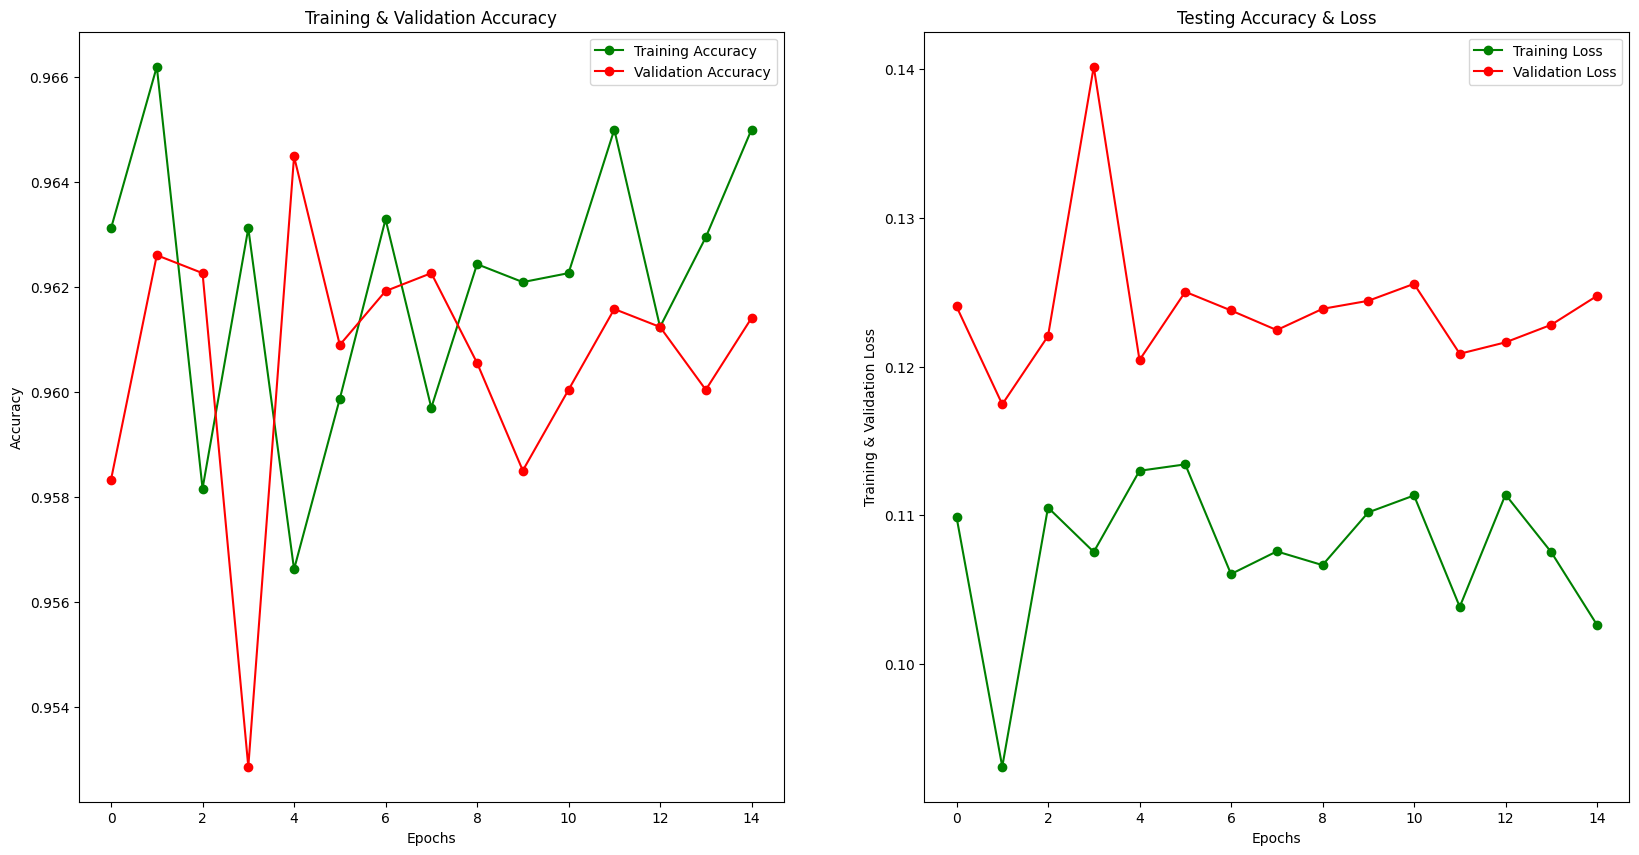

In [46]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [47]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]
predictions[:15]

183/183 [==============================] - 2s 8ms/step


array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [48]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.99      0.86      0.92      4273
   Normal (Class 1)       0.73      0.99      0.84      1583

           accuracy                           0.90      5856
          macro avg       0.86      0.93      0.88      5856
       weighted avg       0.92      0.90      0.90      5856



In [49]:
cm = confusion_matrix(y_test, predictions)
cm

array([[3689,  584],
       [  19, 1564]])

In [50]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

<Axes: >

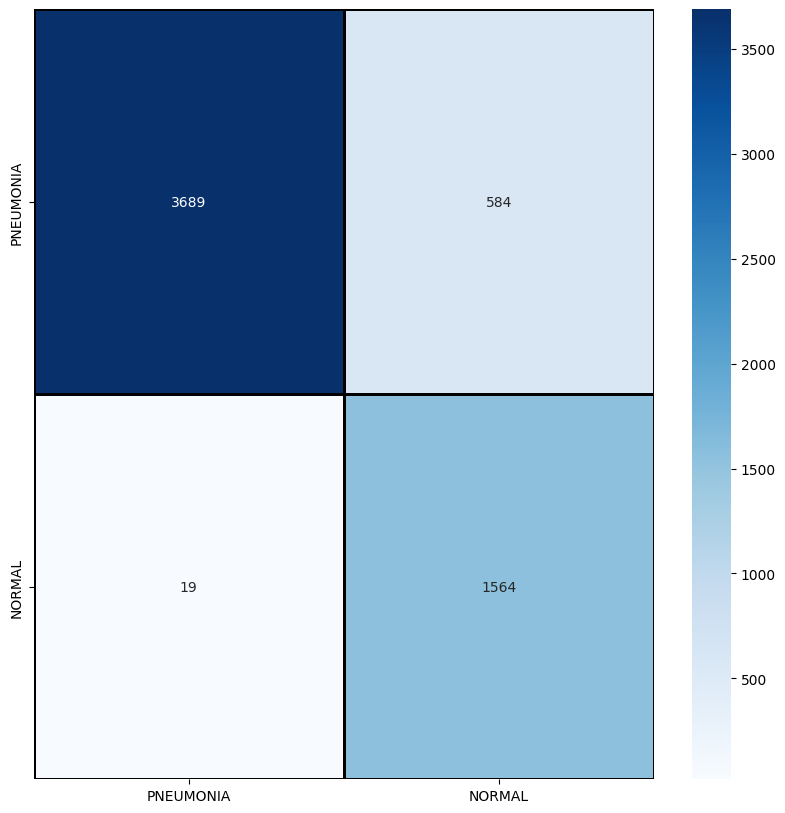

In [51]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [52]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-53-194eb1c1c186>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


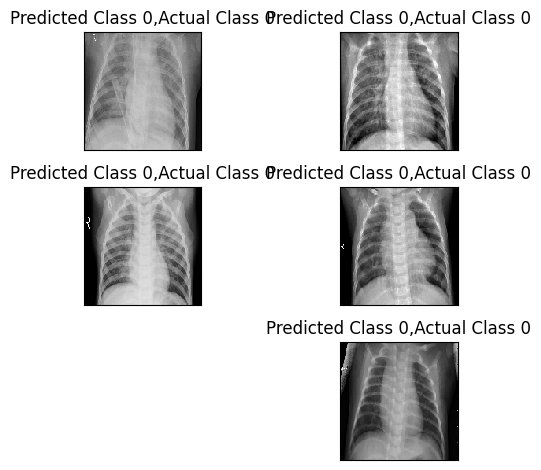

In [53]:
i = 0
for c in correct[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(
        predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

<ipython-input-54-b9cc46b9bc85>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, i+1)


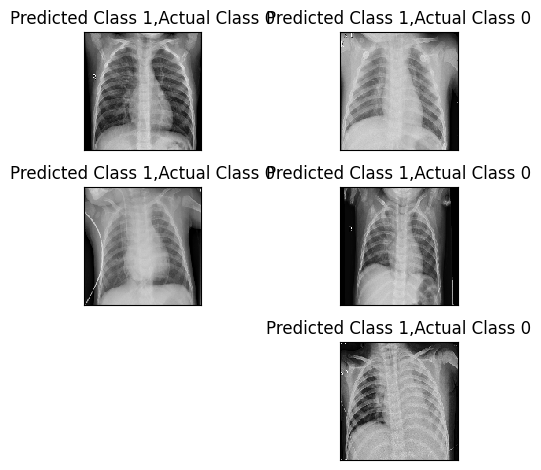

In [54]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[c].reshape(150, 150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1